# Garbage Classification project
This notebook contains all the code which is uploaded from Week-1 & Week-2 and adds improved evaluation tools:
- Model fine-tuning (assumed already trained)
- Final evaluation on test set
- Prediction visualization
- Model saving/loading
- Gradio deployment interface


Note: This notebook is along with the Week-1 & Week-2 code.

## Week 1 - Garbage Classification using EfficientNetV2B2

Improvements in this week:
- Image resized to 260x260 (EfficientNetV2B2 input size)
- Normalization and data augmentation
- Class weight handling for imbalanced dataset
- Model callbacks (EarlyStopping, ReduceLROnPlateau)

In [2]:
# Importing all the libraries

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, optimizers
from tensorflow.keras import Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetV2B2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Image resizing to 260x260 for EfficientNetV2B2

image_size = (260, 260)
batch_size = 32
seed = 42
dataset_dir = '/content/drive/MyDrive/Garbage_Classification_Dataset'

In [5]:
# splitting the training dataset from the images dataset

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='training',
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)

Found 2527 files belonging to 6 classes.
Using 2022 files for training.


In [6]:
# splitting the validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset='validation',
    seed=seed,
    shuffle=True,
    image_size=image_size,
    batch_size=batch_size
)
val_class = val_ds.class_names

Found 2527 files belonging to 6 classes.
Using 505 files for validation.


In [7]:
# Get the total number of batches in the validation dataset
val_batches = tf.data.experimental.cardinality(val_ds)

# Split the validation dataset into two equal parts:
# First half becomes the test dataset
test_ds = val_ds.take(val_batches // 2)

# Second half remains as the validation dataset
val_dat = val_ds.skip(val_batches // 2)

# Optimize test dataset by caching and prefetching to improve performance
test_ds_eval = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [8]:
print(train_ds.class_names)
print(val_class)
print(len(train_ds.class_names))

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
6


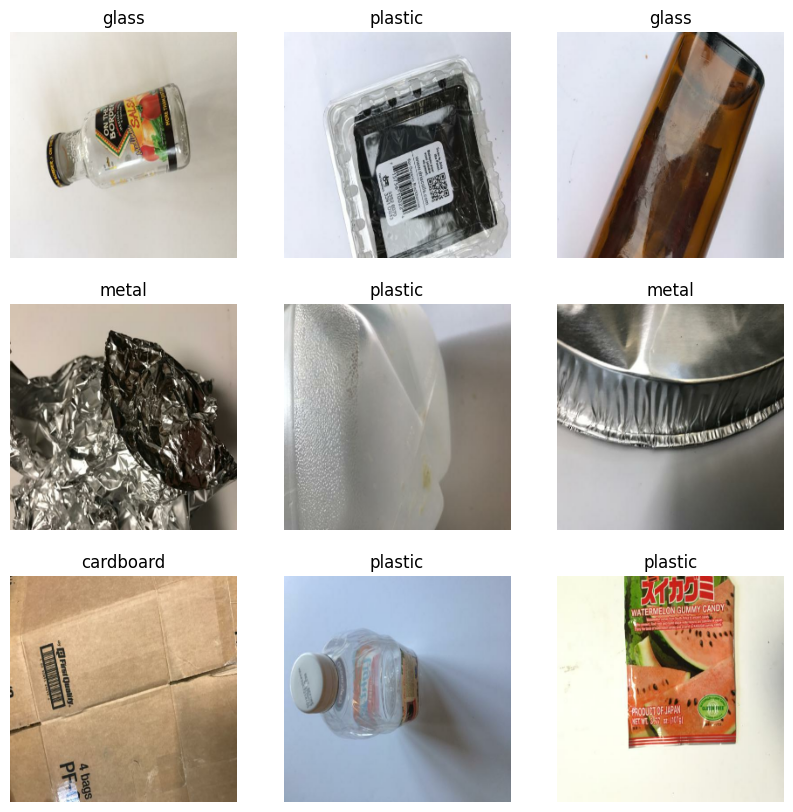

In [9]:
plt.figure(figsize=(10, 10))

# 9 random images from the training dataset
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(train_ds.class_names[labels[i]])
        plt.axis('off')

In [10]:
# Function to distribute percentages
def count_distribution(dataset, class_names):
    total = 0
    counts = {name: 0 for name in class_names}

    for _, labels in dataset:
        for label in labels.numpy():
            class_name = class_names[label]
            counts[class_name] += 1
            total += 1

    for k in counts:
        counts[k] = round((counts[k] / total) * 100, 2)
    return counts

In [11]:
# Function to plot class distribution
def simple_bar_plot(dist, title):
    plt.bar(dist.keys(), dist.values(), color='cornflowerblue')
    plt.title(title)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45)
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()


In [12]:
class_names = train_ds.class_names

# Getting distributions for all the datasets
train_dist = count_distribution(train_ds, class_names)
val_dist = count_distribution(val_ds, class_names)
test_dist = count_distribution(test_ds, class_names)
overall_dist = {}

for k in class_names:
    overall_dist[k] = round((train_dist[k] + val_dist[k]) / 2, 2)

print(train_dist)
print(val_dist)
print(test_dist)
print(overall_dist)

{'cardboard': 16.52, 'glass': 19.73, 'metal': 15.92, 'paper': 23.29, 'plastic': 19.44, 'trash': 5.09}
{'cardboard': 13.66, 'glass': 20.2, 'metal': 17.43, 'paper': 24.36, 'plastic': 17.62, 'trash': 6.73}
{'cardboard': 14.06, 'glass': 17.58, 'metal': 16.8, 'paper': 25.0, 'plastic': 19.14, 'trash': 7.42}
{'cardboard': 15.09, 'glass': 19.96, 'metal': 16.68, 'paper': 23.82, 'plastic': 18.53, 'trash': 5.91}


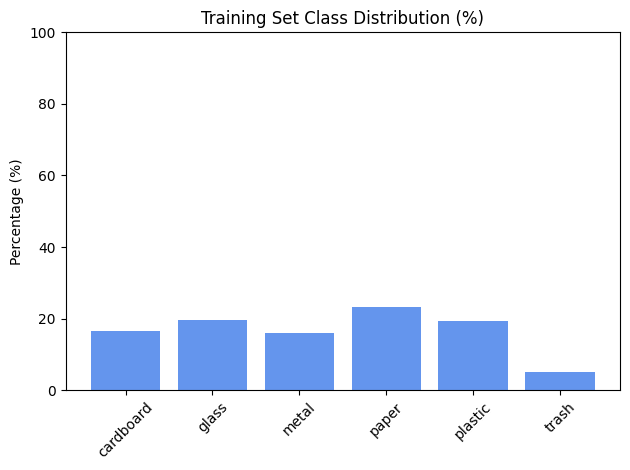

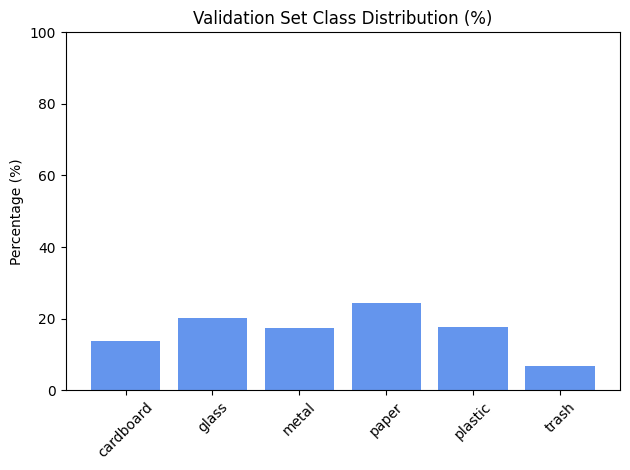

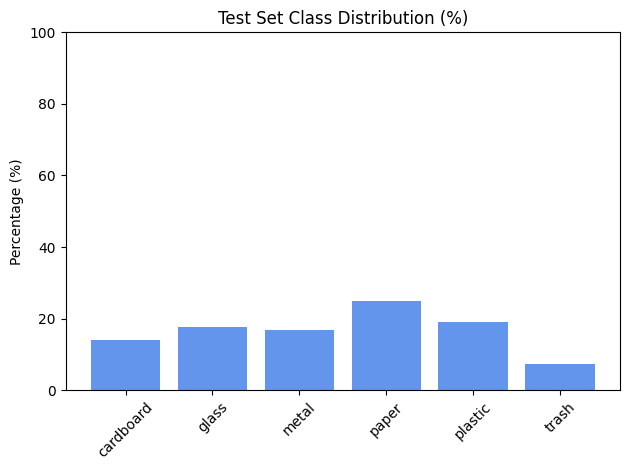

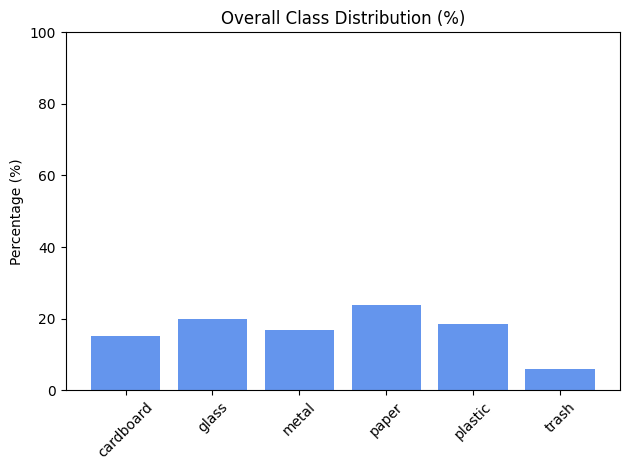

In [13]:
# Visualizations of all classes in the datasets
simple_bar_plot(train_dist, "Training Set Class Distribution (%)")
simple_bar_plot(val_dist, "Validation Set Class Distribution (%)")
simple_bar_plot(test_dist, "Test Set Class Distribution (%)")
simple_bar_plot(overall_dist, "Overall Class Distribution (%)")

In [14]:
# Count class occurrences and prepare label list
class_counts = {i: 0 for i in range(len(class_names))}
all_labels = []

for images, labels in train_ds:
    for label in labels.numpy():
        class_counts[label] += 1
        all_labels.append(label)

# Compute class weights (index aligned)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(len(class_names)),
    y=all_labels
)

# Create dictionary mapping class index to weight
class_weights = {i: w for i, w in enumerate(class_weights_array)}

In [15]:
print("Class Counts:", class_counts)
print("Class Weights:", class_weights)

Class Counts: {0: 334, 1: 399, 2: 322, 3: 471, 4: 393, 5: 103}
Class Weights: {0: np.float64(1.0089820359281436), 1: np.float64(0.8446115288220551), 2: np.float64(1.046583850931677), 3: np.float64(0.7154989384288747), 4: np.float64(0.8575063613231552), 5: np.float64(3.2718446601941746)}


In [16]:
# Data pre processing
data_augmentation = keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2)
])

In [17]:
# Load the EfficientNetV2B2 model
base_model = EfficientNetV2B2(include_top=False, input_shape=(260, 260, 3), weights='imagenet', include_preprocessing=True)
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False


35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Final model
model = Sequential([
    layers.Input(shape=(260, 260, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])



In [19]:
# Model compiling
model.compile(optimizer=optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [20]:
# Callbacks

early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5)
checkpoint = callbacks.ModelCheckpoint('best_model.h5', save_best_only=True)

In [21]:
# Training the model

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

Epoch 1/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.3563 - loss: 1.6269

64/64 ━━━━━━━━━━━━━━━━━━━━ 85s 521ms/step - accuracy: 0.3584 - loss: 1.6240 - val_accuracy: 0.7584 - val_loss: 0.8881 - learning_rate: 1.0000e-04
Epoch 2/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7405 - loss: 0.8877

64/64 ━━━━━━━━━━━━━━━━━━━━ 28s 406ms/step - accuracy: 0.7410 - loss: 0.8862 - val_accuracy: 0.8752 - val_loss: 0.4628 - learning_rate: 1.0000e-04
Epoch 3/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step - accuracy: 0.8575 - loss: 0.4984

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 412ms/step - accuracy: 0.8575 - loss: 0.4978 - val_accuracy: 0.9089 - val_loss: 0.3041 - learning_rate: 1.0000e-04
Epoch 4/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9038 - loss: 0.3337

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.9037 - loss: 0.3336 - val_accuracy: 0.9089 - val_loss: 0.2468 - learning_rate: 1.0000e-04
Epoch 5/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9233 - loss: 0.2387

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 411ms/step - accuracy: 0.9233 - loss: 0.2388 - val_accuracy: 0.9307 - val_loss: 0.2209 - learning_rate: 1.0000e-04
Epoch 6/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9448 - loss: 0.1710

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 409ms/step - accuracy: 0.9448 - loss: 0.1710 - val_accuracy: 0.9228 - val_loss: 0.1805 - learning_rate: 1.0000e-04
Epoch 7/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.9609 - loss: 0.1291

64/64 ━━━━━━━━━━━━━━━━━━━━ 26s 404ms/step - accuracy: 0.9607 - loss: 0.1292 - val_accuracy: 0.9406 - val_loss: 0.1652 - learning_rate: 1.0000e-04
Epoch 8/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 391ms/step - accuracy: 0.9572 - loss: 0.1247 - val_accuracy: 0.9386 - val_loss: 0.1785 - learning_rate: 1.0000e-04
Epoch 9/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step - accuracy: 0.9662 - loss: 0.1145 - val_accuracy: 0.9347 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 10/15
64/64 ━━━━━━━━━━━━━━━━━━━━ 24s 374ms/step - accuracy: 0.9722 - loss: 0.0776 - val_accuracy: 0.9426 - val_loss: 0.1735 - learning_rate: 5.0000e-05


In [22]:
# Summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 260, 260, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b2 (Functional)  │ (None, 9, 9, 1408)     │     8,769,374 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1408)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1408)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │         8,454 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,727,114 (94.33 MB)

 Trainable params: 7,974,642 (30.42 MB)

 Non-trainable params: 803,186 (3.06 MB)

 Optimizer params: 15,949,286 (60.84 MB)

In [23]:
# Print the architecture summary of the base model
base_model.summary()

Model: "efficientnetv2-b2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 260, 260,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 260, 260,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 260, 260,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 130, 130,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 130, 130,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 130, 130,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 130, 130,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 130, 130,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 130, 130,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 130, 130,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 130, 130,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 130, 130,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 130, 130,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 65, 65,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 65, 65,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 65, 65,    │          0 │ block2a_expand_b

 Total params: 8,769,374 (33.45 MB)

 Trainable params: 7,966,188 (30.39 MB)

 Non-trainable params: 803,186 (3.06 MB)

## Week 2 - Evaluation Enhancements
- Test/validation split
- Confusion matrix
- Classification report
- Training data visualization


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

In [25]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_dat = val_ds.skip(val_batches // 2)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [26]:
test_images = []
test_labels = []
for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

x_test = tf.concat(test_images, axis=0)
y_test = tf.concat(test_labels, axis=0)

In [27]:
y_pred_probs = model.predict(x_test)
y_pred = tf.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.96      0.96        28
       glass       0.96      0.98      0.97        55
       metal       0.98      0.91      0.94        44
       paper       0.98      0.97      0.98        63
     plastic       0.93      0.91      0.92        47
       trash       0.83      1.00      0.90        19

    accuracy                           0.95       256
   macro avg       0.94      0.96      0.95       256
weighted avg       0.96      0.95      0.95       256



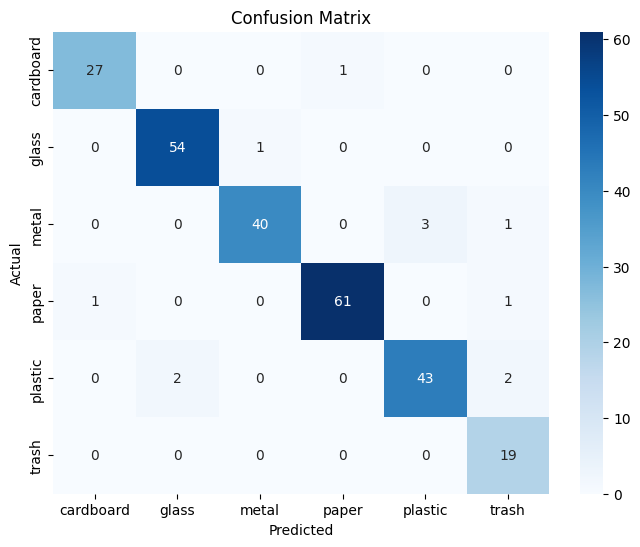

In [28]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

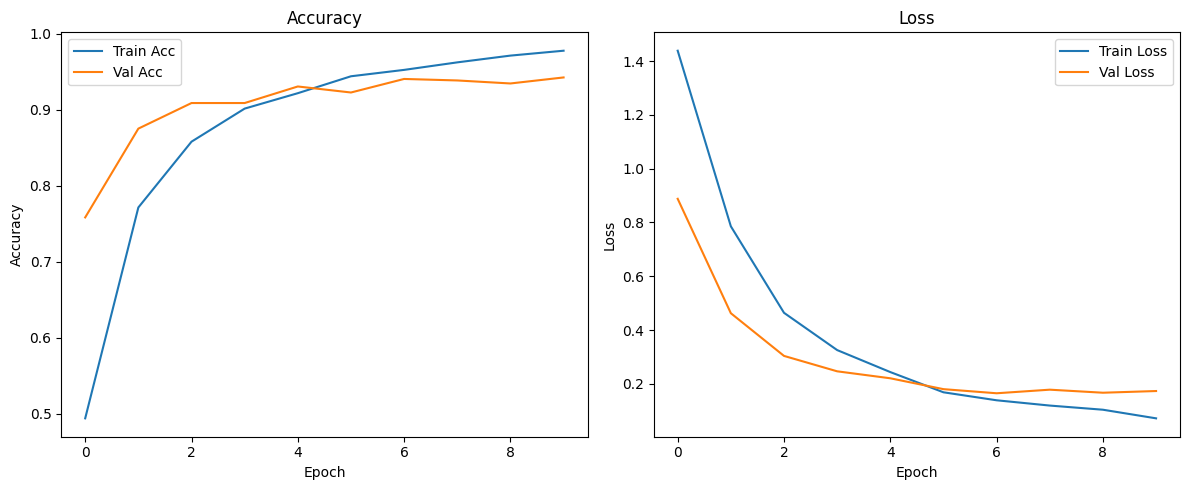

In [29]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

## Week 3 – Model Fine-Tuning and Final Evaluation
- Fine-tuning EfficientNetV2B2
- Stronger data augmentation
- Grad-CAM visualization
- Final evaluation on test set

In [30]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
    layers.RandomContrast(0.3),
    layers.RandomTranslation(0.2, 0.2)
])

In [31]:
# Rebuild model for fine-tuning
base_model = EfficientNetV2B2(include_top=False, weights='imagenet', input_shape=(260, 260, 3), include_preprocessing=True)
base_model.trainable = True  # Unfreeze all layers (or select range if needed)
for layer in base_model.layers[:150]:  # Freeze first 150 layers
    layer.trainable = False

model = Sequential([
    layers.Input(shape=(260, 260, 3)),
    data_augmentation,
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
history = model.fit(
    train_ds,
    validation_data=val_dat,
    epochs=10,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint('best_model_finetuned.h5', save_best_only=True)
    ]
)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.1663 - loss: 1.8421

64/64 ━━━━━━━━━━━━━━━━━━━━ 68s 416ms/step - accuracy: 0.1665 - loss: 1.8416 - val_accuracy: 0.2249 - val_loss: 1.7668
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.2524 - loss: 1.7381

64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 346ms/step - accuracy: 0.2527 - loss: 1.7377 - val_accuracy: 0.3655 - val_loss: 1.6653
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.3245 - loss: 1.6674

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 335ms/step - accuracy: 0.3250 - loss: 1.6670 - val_accuracy: 0.4578 - val_loss: 1.5669
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.4266 - loss: 1.5765

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 359ms/step - accuracy: 0.4270 - loss: 1.5761 - val_accuracy: 0.4458 - val_loss: 1.5102
Epoch 5/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.5004 - loss: 1.4838

64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 334ms/step - accuracy: 0.5005 - loss: 1.4834 - val_accuracy: 0.5502 - val_loss: 1.4090
Epoch 6/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.5580 - loss: 1.3795

64/64 ━━━━━━━━━━━━━━━━━━━━ 23s 350ms/step - accuracy: 0.5581 - loss: 1.3795 - val_accuracy: 0.6185 - val_loss: 1.3203
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5958 - loss: 1.3188

64/64 ━━━━━━━━━━━━━━━━━━━━ 40s 337ms/step - accuracy: 0.5958 - loss: 1.3186 - val_accuracy: 0.6305 - val_loss: 1.2084
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6572 - loss: 1.2205

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.6570 - loss: 1.2203 - val_accuracy: 0.6586 - val_loss: 1.1428
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.6480 - loss: 1.1716

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 350ms/step - accuracy: 0.6481 - loss: 1.1712 - val_accuracy: 0.6908 - val_loss: 1.0386
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.6730 - loss: 1.0936

64/64 ━━━━━━━━━━━━━━━━━━━━ 41s 343ms/step - accuracy: 0.6731 - loss: 1.0934 - val_accuracy: 0.7068 - val_loss: 0.9747


In [33]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step
Final Classification Report:
              precision    recall  f1-score   support

   cardboard       0.65      0.79      0.71        28
       glass       0.88      0.65      0.75        55
       metal       0.63      0.75      0.69        44
       paper       0.85      0.65      0.74        63
     plastic       0.61      0.72      0.66        47
       trash       0.40      0.53      0.45        19

    accuracy                           0.69       256
   macro avg       0.67      0.68      0.67       256
weighted avg       0.72      0.69      0.69       256



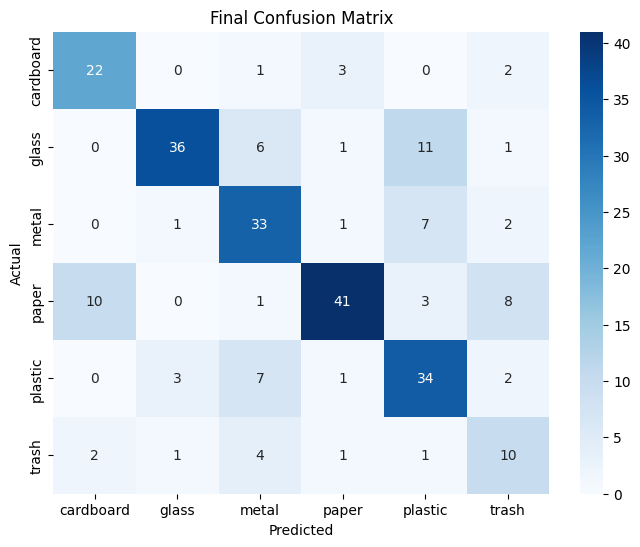

In [34]:
y_pred_probs = model.predict(x_test)
y_pred = tf.argmax(y_pred_probs, axis=1)

print("Final Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Final Confusion Matrix")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


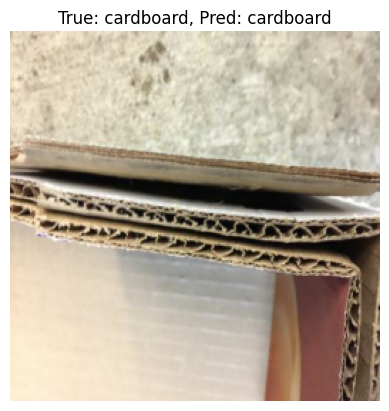

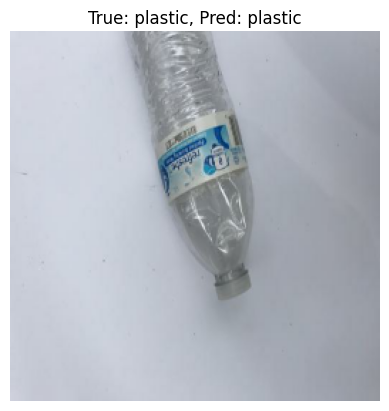

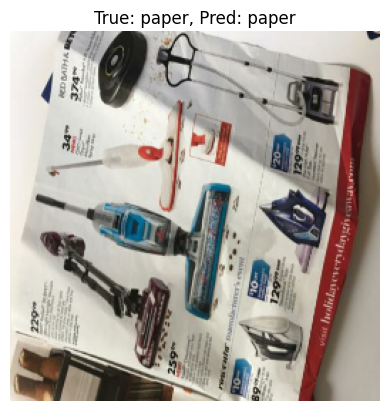

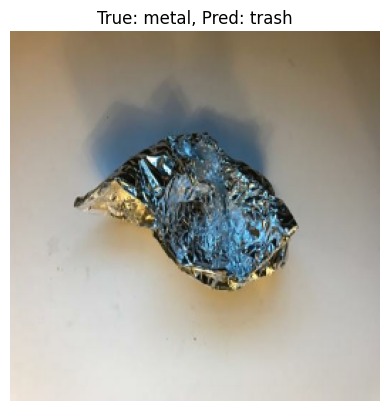

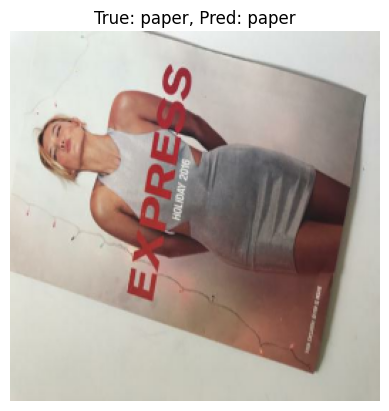

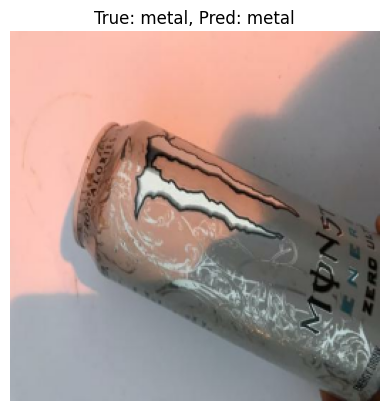

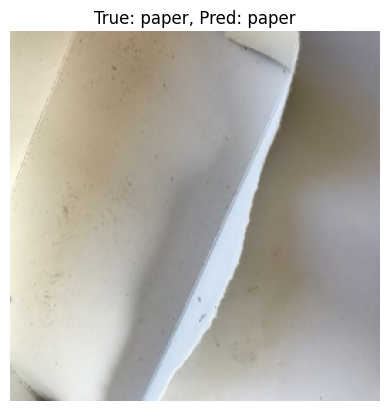

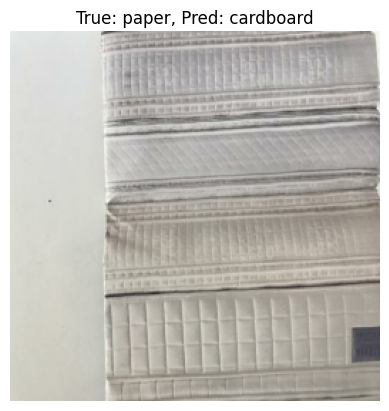

In [35]:
# Visualize sample predictions
for images, labels in test_ds_eval.take(1):
    preds = model.predict(images)
    pred_labels = tf.argmax(preds, axis=1)
    for i in range(8):
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(f"True: {class_names[labels[i]]}, Pred: {class_names[pred_labels[i]]}")
        plt.axis("off")
        plt.show()

In [38]:
class_names = train_ds.class_names  # or manually define as a list


In [39]:
# Make sure test_ds_eval is already defined and batched
y_true = np.concatenate([labels.numpy() for _, labels in test_ds_eval], axis=0)


In [40]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred_probs = model.predict(test_ds_eval)
y_pred = np.argmax(y_pred_probs, axis=1)

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, target_names=class_names))


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 111ms/step
[[24  0  1  4  0  5]
 [ 0 32  5  1  7  0]
 [ 0  2 35  1  8  3]
 [ 6  0  1 51  3  4]
 [ 0  2  4  0 33  3]
 [ 2  1  2  1  1 14]]
              precision    recall  f1-score   support

   cardboard       0.75      0.71      0.73        34
       glass       0.86      0.71      0.78        45
       metal       0.73      0.71      0.72        49
       paper       0.88      0.78      0.83        65
     plastic       0.63      0.79      0.70        42
       trash       0.48      0.67      0.56        21

    accuracy                           0.74       256
   macro avg       0.72      0.73      0.72       256
weighted avg       0.76      0.74      0.74       256



In [41]:
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

def predict_image(img):
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)

    img = img.convert("RGB").resize((260, 260))
    img_array = np.expand_dims(np.array(img), axis=0)

    # Use model-specific preprocessing
    img_array = preprocess_input(img_array)

    preds = model.predict(img_array)
    pred_idx = np.argmax(preds)
    confidence = float(preds[0][pred_idx])
    return f"{class_names[pred_idx]} (Confidence: {confidence:.2f})"


In [42]:
model.save("EfficientNetV2B2_Final.keras")
model = tf.keras.models.load_model("EfficientNetV2B2_Final.keras")


In [43]:
import gradio as gr
gr.Interface(fn=predict_image, inputs="image", outputs="text").launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://e4267fe73d6c624296.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
